### Investigating pinchouts - using unconformity between each lithology

In [1]:
import numpy as np
import pandas as pd
import numbers

bore_data = pd.read_excel("../data/data_simple_example.xls",sheet_name = "bore_data")
strat = pd.read_excel("../data/data_simple_example.xls",sheet_name = "strat")
bore_data

,ID,Easting,Northing,Ground,a,b,c
0,P1,1500,750,0,-50,-70,-
1,P2,1500,250,0,-50,-70,-
2,P3,3500,750,0,-50,-,-
3,P4,3500,250,0,-50,-,-


In [2]:
x0, x1, y0, y1, z0, z1 = 0, 5000, 0, 1000, -200, 100

df = bore_data.copy()
units = list(df.columns.values[3:])   # Make a list of formations  
df.Easting = pd.to_numeric(df.Easting)    # Make sure Eastings and Northings are numeric values
df.Northing = pd.to_numeric(df.Northing)
df.Ground = pd.to_numeric(df.Ground)
print(units)
df

['Ground', 'a', 'b', 'c']


,ID,Easting,Northing,Ground,a,b,c
0,P1,1500,750,0,-50,-70,-
1,P2,1500,250,0,-50,-70,-
2,P3,3500,750,0,-50,-,-
3,P4,3500,250,0,-50,-,-


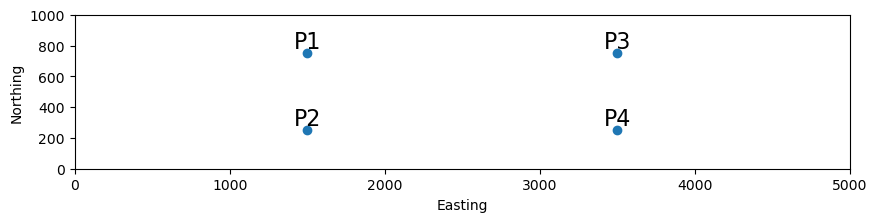

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

figure = True
if figure:
    plt.figure(figsize=(10,2))
    plt.scatter(df.Easting, df.Northing)
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    i = 0
    for (xi, yi) in zip(df.Easting, df.Northing):
        plt.text(xi, yi, df.ID[i], size = 16, va='bottom', ha='center')
        i += 1
        plt.xlim(x0,x1)
        plt.ylim(y0,y1)

### Make lithology table for Loop

In [4]:
from LoopStructural.utils.helper import strike_dip_vector

data_list = df.values.tolist()             # Turn data into a list of lists
formatted_data = []

for i in range(len(data_list)): #iterate for each row
    
    boreid = data_list[i][0]
    easting, northing = data_list[i][1], data_list[i][2]
    groundlevel = data_list[i][3]    
           
    # Add data for groundlevel
    val = strat.val[0]
    gx, gy, gz = 0,0,1 # flat
    formatted_data.append([boreid, easting, northing, groundlevel, val, 'Ground', 'Ground', gx, gy, gz]) 

    # Add data row for each lithology
    count = 1
    for j in range(4,df.shape[1]-1): #iterate through each formation 
        
        # Add lithology
        if isinstance(data_list[i][j], numbers.Number) == True:    
            bottom    = groundlevel + float(data_list[i][j])  # Ground surface - formation bottom (mbgl)
            val       = strat.val[count]                   # designated isovalue
            unit      = strat.unit[count]                  # unit 
            feature   = strat.sequence[count]              # sequence
            gx, gy, gz = 0,0,1                                # normal vector to surface (flat)
            formatted_data.append([boreid, easting, northing, bottom, val, unit, feature, gx, gy, gz])    
            current_bottom = np.copy(bottom)            
        count+=1
        
# For pinchout, add dummy point  
boreid = 'D1'
Deasting, Dnorthing = 2000, 750
bottom = -50
unit    = 'b'   
val       = -70          
feature   = strat.sequence[count]   
#strike, dip = 180, 30
#gx, gy, gz = strike_dip_vector([strike], [dip])[0]   

formatted_data.append([boreid, Deasting, Dnorthing, bottom, val, unit, feature])
        
data = pd.DataFrame(formatted_data)
data.columns =['ID','X','Y','Z','val','lithcode','feature_name', 'gx', 'gy', 'gz']

sequences = data['feature_name'].unique()
data

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz
0,P1,1500,750,0.0,0,Ground,Ground,0.0,0.0,1.0
1,P1,1500,750,-50.0,-50,a,Upper,0.0,0.0,1.0
2,P1,1500,750,-70.0,-70,b,Lower,0.0,0.0,1.0
3,P2,1500,250,0.0,0,Ground,Ground,0.0,0.0,1.0
4,P2,1500,250,-50.0,-50,a,Upper,0.0,0.0,1.0
5,P2,1500,250,-70.0,-70,b,Lower,0.0,0.0,1.0
6,P3,3500,750,0.0,0,Ground,Ground,0.0,0.0,1.0
7,P3,3500,750,-50.0,-50,a,Upper,0.0,0.0,1.0
8,P4,3500,250,0.0,0,Ground,Ground,0.0,0.0,1.0
9,P4,3500,250,-50.0,-50,a,Upper,0.0,0.0,1.0


### Create Geomodel

In [5]:
import LoopStructural
from LoopStructural import GeologicalModel
origin  = (x0, y0, z0)
maximum = (x1, y1, z1)
geomodel = GeologicalModel(origin, maximum)
geomodel.data = data

### Add surfaces

In [6]:
Ground     = geomodel.create_and_add_foliation("Ground")
GroundUC   = geomodel.add_unconformity(Ground, 0)
Upper      = geomodel.create_and_add_foliation("Upper")
UpperUC    = geomodel.add_unconformity(Upper, -50) 
Lower      = geomodel.create_and_add_foliation("Lower") 

In [7]:
geomodel.feature_name_index

{'Ground': 0,
 'Ground_unconformity': 1,
 'Upper': 2,
 'Upper_unconformity': 3,
 'Lower': 4}

### Add Stratigraphy Column

In [8]:
stratigraphic_column = {}
stratigraphic_column["Ground"] = {}
stratigraphic_column["Ground"]["Ground"] = {"min": 0, "max": np.inf, "id": 0}
stratigraphic_column["Upper"] = {}
stratigraphic_column["Upper"]["a"] = {"min": -50, "max": 0, "id": 1}
stratigraphic_column["Lower"] = {}
stratigraphic_column["Lower"]["b"] = {"min": -70, "max": -50, "id": 2}
stratigraphic_column["Lower"]["c"] = {"min": -np.inf, "max": -70, "id": 3}
stratigraphic_column

{'Ground': {'Ground': {'min': 0, 'max': inf, 'id': 0}},
 'Upper': {'a': {'min': -50, 'max': 0, 'id': 1}},
 'Lower': {'b': {'min': -70, 'max': -50, 'id': 2},
  'c': {'min': -inf, 'max': -70, 'id': 3}}}

### 3D View

In [9]:
#from LoopStructural.visualisation import LavaVuModelViewer
#viewer =  LavaVuModelViewer(geomodel)
#viewer.add_isosurface(Ground, colour = 'green')
#viewer.add_isosurface(Upper, colour = 'purple')
#viewer.add_isosurface(Lower, colour = 'blue')
#viewer.set_zscale(zscale = 5)
#viewer.interactive()

### 2D View

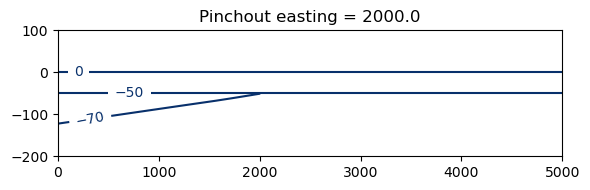

In [10]:
sequence_list = ["Ground", "Upper", "Lower"]
y_transects = [500]

fig, ax = plt.subplots(1,1,figsize=(6,2))

delx, delz = 100, 200
x, z = np.linspace(x0,x1,delx), np.linspace(z0,z1,delz)
xx, zz = np.meshgrid(x,z)
yy = np.zeros_like(xx)
yy[:] = 500
ax.set_title('Pinchout easting = %0.1f' %Deasting)

for i, seq in enumerate(sequence_list):
    levels = [-999, strat.val[i]]
    vals = geomodel.evaluate_feature_value(seq, np.array([xx.flatten(),yy.flatten(),zz.flatten()]).T)
    con = ax.contour(vals.reshape((delz, delx)), levels = levels, extent=(x0, x1, z0, z1), cmap = 'Blues')
    ax.clabel(con, inline=True, fontsize=10)

plt.tight_layout() 

plt.show()
